I did not pay much attention to the Cifar-10 convnet and was reaching accuracy of about 65%. That's why I did not want to use it as my base and instead I decided to try to use the models packed with Keras - that immediately lead me to the problem that the resolution of the images in Cifar-100 is too small. After looking at the architectures of the models I just decided to use the VGG16 as it is the most shallow one and cuts down the dimensions the least.

To cope with the problem of too small images I was trying to change the way of pooling (padding and strides so that the first two dimensions of the input would stay the same) and/or cutting the last layers off. The approach with which I have achieved the best results was to only adjust the first two pooling layers (I did not want to change more as that would inflate the size of the output tensors and perhaps without a tangible benefit) - this also fits with my hypothesis that doing this near the beginning still retains a lot of information from the images, however, in latter layers the information gets too mangled and doing a max-pool on 1x1 does not give sense...

I was using the test data as validation data to tweak the hyperparemeters - but only on filtered pictures containing only 3 categories (bears, otters, wolves - I wanted to know how well it would do in a forest :) ). In the end I tried to evaluate it (no longer changing the model) also on different categories - which did better (probably because the categories had much more prominent differences) - the first time I tried to evaluate it on different categories the final accuracy was around 99% (and using less epochs), rerunning this notebook (and thus selecting different evaluation categories as I choose them at random) gave the accuracy of 95%, on the original categories 89% and it looks like I could have been training a bit longer.

Overall, I am pretty happy with the results as the resolution is really low and I presume the convolutional base would be able to extract better features having higher resolution... (Actually, I wonder a bit how come it performed so well as ImageNet has much more subtle low-level features)

In [1]:
# for switching between GPU and CPU
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100

Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    """Displays images in a grid"""
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    rows = np.ceil(len(images)/columns).astype('int')
    
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
    plt.show()
    
def show_random_imgs(images, title=''):
    indices = np.random.choice(range(len(images)), 45, replace=0)
    show_imgs(images[indices], title=title)

In [5]:
def filter_categories(input_set, target_set, categories):
    categories = set(categories)
    
    indices = np.apply_along_axis(
        lambda category: category[0] in categories,
        axis=-1,
        arr=target_set)
    
    recatg_map = dict(zip(categories, range(len(categories))))
    
    transformed_target_categories = np.apply_along_axis(
        lambda category: recatg_map[category[0]],
        axis=-1,
        arr=target_set[indices])
    
    return input_set[indices], transformed_target_categories

## Loading the datasets

In [6]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

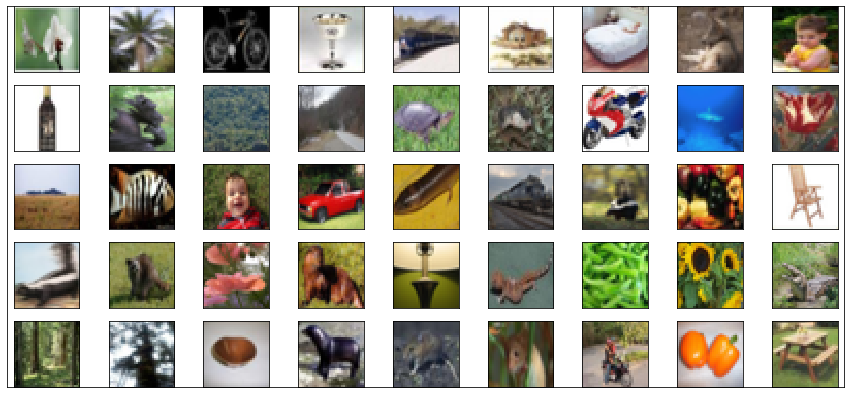

In [7]:
show_random_imgs(x_train)

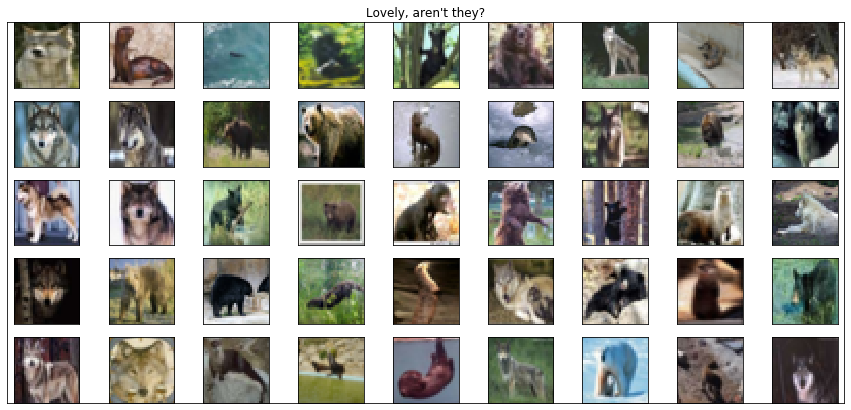

In [8]:
categories = {3,55,97} # bears, otters, wolves

xf_train, yf_train = filter_categories(x_train, y_train, categories)
xf_test, yf_test = filter_categories(x_test, y_test, categories)

# one-hot potato
yf_train = keras.utils.to_categorical(yf_train)
yf_test = keras.utils.to_categorical(yf_test)
assert yf_train.shape[1] == len(categories)

show_random_imgs(xf_train, "Lovely, aren't they?")

In [9]:
locomotive_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = locomotive_datagen.flow(
    xf_train,
    yf_train,
    batch_size=50
)

## Working on the model

In [10]:
print(xf_train.shape)

(1500, 32, 32, 3)


In [11]:
from keras.applications import VGG16 as ConvBase

conv_base = ConvBase(
    include_top=False,
    weights='imagenet',
    input_shape=None)

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [12]:
for l in conv_base.layers:
    if 'pool' in l.name and ('1' in l.name or '2' in l.name):
        l.padding='same'
        l.strides=(1,1)
        
conv_base.trainable=False

In [13]:
model = build_model(
    kl.InputLayer(xf_train.shape[1:]),
    conv_base,
    kl.Flatten(),
    kl.Dropout(.35),
    kl.Dense(256, activation='relu'),
    kl.Dropout(.3),
    kl.Dense(128, activation='relu'),
    kl.Dense(3, activation='softmax'),
    verbose=True,
    optimizer=keras.optimizers.RMSprop(lr=1e-4)
)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387   

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=80,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

Epoch 1/80


/home/martin/.local/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


30/30 [==============================] - 16s 540ms/step - loss: 1.0780 - acc: 0.4740 - val_loss: 1.0622 - val_acc: 0.3933
Epoch 2/80
30/30 [==============================] - 5s 152ms/step - loss: 1.0018 - acc: 0.5020 - val_loss: 0.9508 - val_acc: 0.5267
Epoch 3/80
30/30 [==============================] - 5s 152ms/step - loss: 0.9571 - acc: 0.5313 - val_loss: 0.8635 - val_acc: 0.6000
Epoch 4/80
30/30 [==============================] - 5s 152ms/step - loss: 0.9467 - acc: 0.5513 - val_loss: 0.8922 - val_acc: 0.5967
Epoch 5/80
30/30 [==============================] - 5s 152ms/step - loss: 0.8497 - acc: 0.6033 - val_loss: 0.7695 - val_acc: 0.6500
Epoch 6/80
30/30 [==============================] - 5s 152ms/step - loss: 0.8701 - acc: 0.5907 - val_loss: 0.8082 - val_acc: 0.6467
Epoch 7/80
30/30 [==============================] - 5s 151ms/step - loss: 0.8862 - acc: 0.5773 - val_loss: 0.7711 - val_acc: 0.6600
Epoch 8/80
30/30 [==============================] - 5s 151ms/step - loss: 0.8416 - acc

In [ ]:
plot_history(hist)

In [ ]:
conv_base.trainable = True
for l in conv_base.layers[:-4]: l.trainable=False

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=160,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

In [ ]:
plot_history(hist)

# And again...
Let's see how it performs on some random categories

In [ ]:
categories = set(np.random.choice(range(100), 3, False))
print(categories)

xf_train, yf_train = filter_categories(x_train, y_train, categories)
xf_test, yf_test = filter_categories(x_test, y_test, categories)

# one-hot potato
yf_train = keras.utils.to_categorical(yf_train)
yf_test = keras.utils.to_categorical(yf_test)
assert yf_train.shape[1] == len(categories)

show_random_imgs(xf_train, "Lovely, aren't they?")

In [ ]:
locomotive_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = locomotive_datagen.flow(
    xf_train,
    yf_train,
    batch_size=50
)

In [ ]:
from keras.applications import VGG16 as ConvBase

conv_base = ConvBase(
    include_top=False,
    weights='imagenet',
    input_shape=None)

conv_base.summary()

In [ ]:
for l in conv_base.layers:
    if 'pool' in l.name and ('1' in l.name or '2' in l.name):
        l.padding='same'
        l.strides=(1,1)
        
conv_base.trainable=False

In [ ]:
model = build_model(
    kl.InputLayer(xf_train.shape[1:]),
    conv_base,
    kl.Flatten(),
    kl.Dropout(.3),
    kl.Dense(256, activation='relu'),
    kl.Dropout(.3),
    kl.Dense(128, activation='relu'),
    kl.Dense(3, activation='softmax'),
    verbose=True,
    optimizer=keras.optimizers.RMSprop(lr=1e-4)
)

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=50,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

In [ ]:
plot_history(hist)

In [ ]:
conv_base.trainable = True
for l in conv_base.layers[:-4]: l.trainable=False

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=100,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

In [ ]:
plot_history(hist)